In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd

from fiona.crs import from_epsg

import os

### Get geometries.

In [2]:
cities = list(pd.read_sql("SELECT name FROM census_place_2018 WHERE top20;", cen_con).name)

city_tracts_sql = """
SELECT pl.state, pl.name, tr18.geoid, tr18.geom geom
FROM   census_tracts_2018 tr18, census_place_2018 pl
WHERE 
  pl.state = tr18.state AND pl.top20 AND
  ST_Intersects(tr18.geom, pl.geom) AND
  ST_Area(ST_Intersection(tr18.geom, pl.geom)) > ST_Area(tr18.geom) / 2;
"""

geo_tracts = gpd.read_postgis(city_tracts_sql, con = cen_con, 
                              index_col = "geoid", geom_col = "geom", crs = from_epsg(2163))

city_tracts = geo_tracts.name.to_dict()

### FCC Notes

* Contractually obligated numbers usually not filled in -- e.g., never non-zero for Comcast.
* Fixing the only real problem for 2010 to 2018 in cities: 
  * There are two mismatched tracts -- one in NYC and the other in LA -- weird cases of changes on the edge of the cities.  LA was a contorted boundary of an old tract by Calabasas.  In NYC it's like a "landing" tract in Staten Island that we can drop).

```
SELECT tr10.geoid tr10
FROM census_tracts_2010 tr10
LEFT JOIN census_tracts_2018 tr18 ON 
  tr10.state = tr18.state AND 
  tr10.county = tr18.county AND 
  tr10.tract = tr18.tract 
JOIN census_place_2018 pl ON 
  ST_Intersects(tr10.geom, pl.geom) AND
  pl.top20
WHERE 
  tr18.geoid IS NULL;
```

In [3]:
fcc = pd.read_csv("data/fcc_tract.csv.gz")

#  The only city tract
fcc.replace({"geoid" : {6037930401 : 6037137000}}, inplace = True)

### ACS

In [4]:
acs = pd.read_csv("data/acs_2018.csv.gz", 
                  usecols = ["geoid", "Broadband", "Computer", "BA", "logMHI", "Black", "Hispanic"])

acs["city"] = acs.geoid.replace(city_tracts)
acs.loc[~acs.geoid.isin(city_tracts), "city"] = np.nan

### Merge them...

In [5]:
acs_fcc = pd.merge(acs, fcc).set_index("geoid")
acs_fcc_geo = geo_tracts.join(acs_fcc)

### Plot Chicago

In [6]:
chicago = acs_fcc_geo.query("name == 'Chicago'").dropna().to_crs(epsg = 3528)

In [7]:
style_kws = {"cmap" : "Blues", "linewidth" : 0.1, "edgecolor" : "k", "legend" : True}

mpl.rcParams['hatch.linewidth'] = 0.1
na_style_kws = {"alpha" : 1, "edgecolor" : "k", "legend" : False,
                "hatch" : "//////////", "color" : "w", "linewidth" : 0.1}

/home/jsaxon/anaconda3/lib/python3.5/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)
/home/jsaxon/anaconda3/lib/python3.5/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)
/home/jsaxon/anaconda3/lib/python3.5/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)
/home/jsaxon/anaconda3/lib/python3.5/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


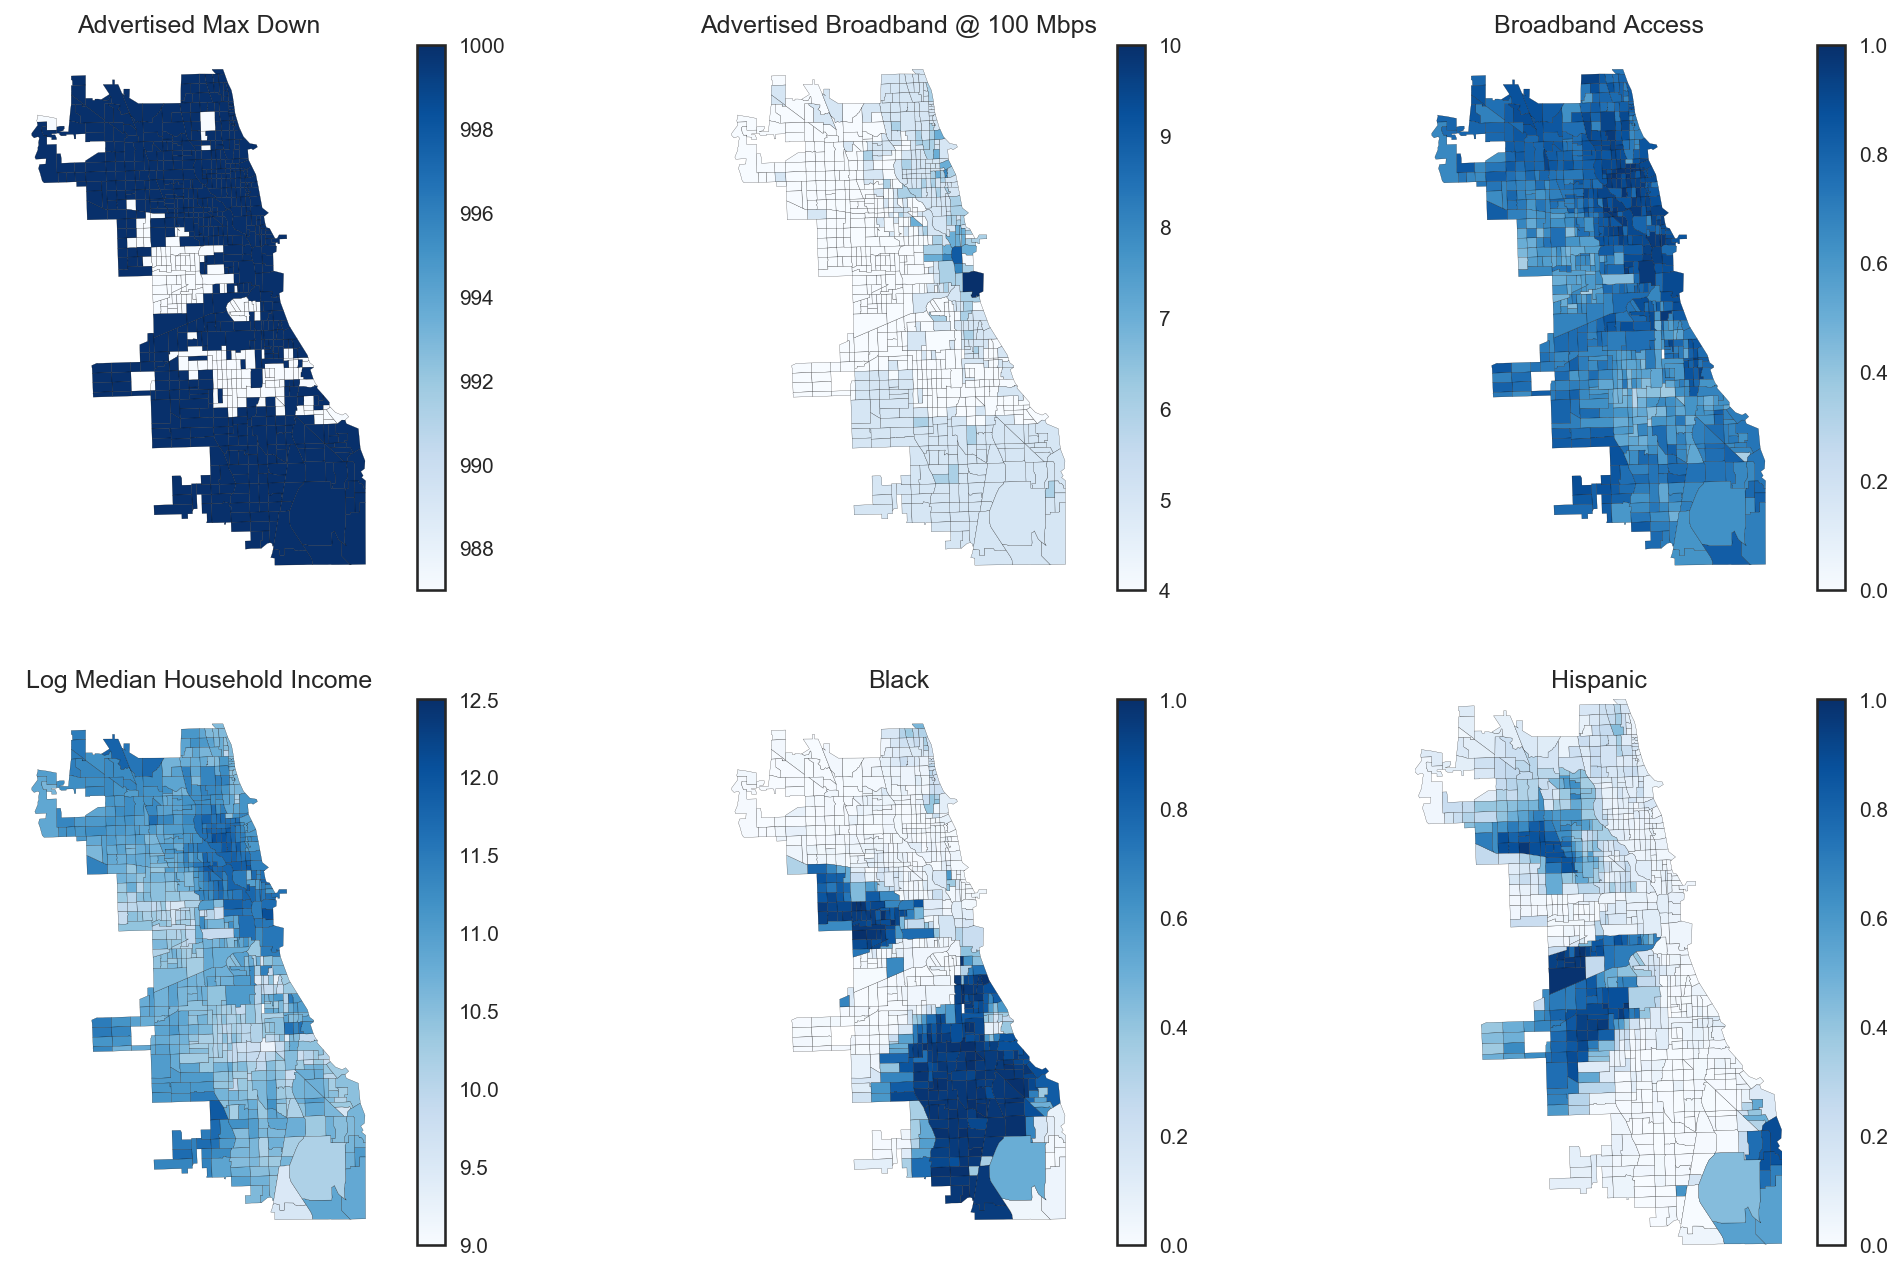

In [19]:
fig, ax = plt.subplots(2, 3, figsize = (14, 8))

for axi in ax.flatten(): map_format(axi)

ax[0][0].set_title("Advertised Max Down")
chicago.plot(column = "maxdowna", **style_kws, ax = ax[0][0])

ax[0][1].set_title("Advertised Broadband @ 100 Mbps")
chicago.plot(column = "n100a", vmax = 10, **style_kws, ax = ax[0][1])

ax[0][2].set_title("Broadband Access")
chicago.plot(column = "Broadband", vmin = 0, vmax = 1, **style_kws, ax = ax[0][2])
chicago[chicago["Broadband"] < 0].plot(**na_style_kws, ax = ax[0][2])

ax[1][0].set_title("Log Median Household Income")
chicago.plot(column = "logMHI", vmin = 9, vmax = 12.5, **style_kws, ax = ax[1][0])
chicago[chicago["logMHI"].isna()].plot(**na_style_kws, ax = ax[1][0])

ax[1][1].set_title("Black")
chicago.plot(column = "Black", vmin = 0, vmax = 1, **style_kws, ax = ax[1][1])
chicago[chicago["Black"] < 0].plot(**na_style_kws, ax = ax[1][1])

ax[1][2].set_title("Hispanic")
chicago.plot(column = "Hispanic", vmin = 0, vmax = 1, **style_kws, ax = ax[1][2])
chicago[chicago["Hispanic"] < 0].plot(**na_style_kws, ax = ax[1][2])

plt.subplots_adjust(hspace = 0.20)

fig.savefig("fcc_maps.pdf")
fig.savefig("fcc_maps.png", bbox_inches = "tight", pad_inches = 0.1, dpi = 300)

Text(0.6,1.08,'Broadband Access on the South Side')

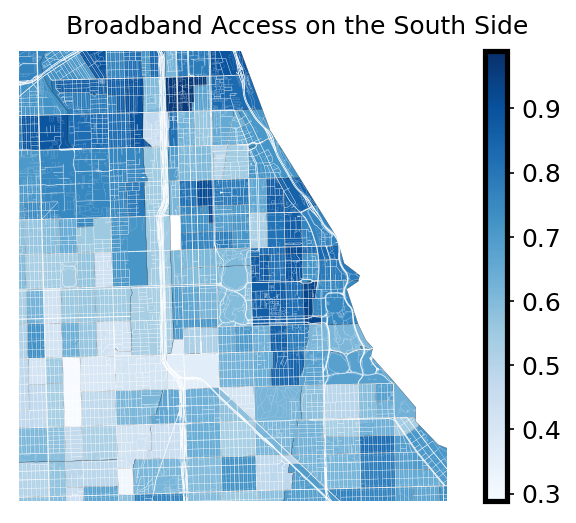

In [9]:
ax = chicago.plot(column = "Broadband", **style_kws, figsize = (5, 3))

streets = gpd.read_file("streets_lw.geojson")
streets.plot(color = "w", lw = streets.highway_thickness / 10, ax = ax)

map_format(ax)
ax.set_xlim(355000, 365000)
ax.set_ylim(564500, 575000)

ax.figure.suptitle("Broadband Access on the South Side", x = 0.6, y = 1.08)

### Now let's investigate a bit...

In [10]:
chicago[["logMHI", "BA", "Black", "Hispanic", "Broadband", "nisp", "n25a", "n100a", "maxdowna"]]\
    .corr().abs().round(3).style.background_gradient(cmap='viridis')

,logMHI,BA,Black,Hispanic,Broadband,nisp,n25a,n100a,maxdowna
logMHI,1,0.758,0.651,0.008,0.822,0.32,0.302,0.302,0.437
BA,0.758,1,0.502,0.306,0.764,0.425,0.421,0.421,0.38
Black,0.651,0.502,1,0.538,0.607,0.093,0.078,0.078,0.285
Hispanic,0.008,0.306,0.538,1,0.061,0.276,0.276,0.276,0.011
Broadband,0.822,0.764,0.607,0.061,1,0.333,0.324,0.324,0.401
nisp,0.32,0.425,0.093,0.276,0.333,1,0.961,0.961,0.363
n25a,0.302,0.421,0.078,0.276,0.324,0.961,1,1,0.386
n100a,0.302,0.421,0.078,0.276,0.324,0.961,1,1,0.386
maxdowna,0.437,0.38,0.285,0.011,0.401,0.363,0.386,0.386,1


In [11]:
chicago.corr().Broadband.abs().sort_values(ascending = False)[1:].round(3)

Computer    0.904
logMHI      0.822
BA          0.764
Black       0.607
maxdowna    0.401
nisp        0.333
n100a       0.324
n25a        0.324
Hispanic    0.061
state         NaN
Name: Broadband, dtype: float64

/home/jsaxon/anaconda3/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


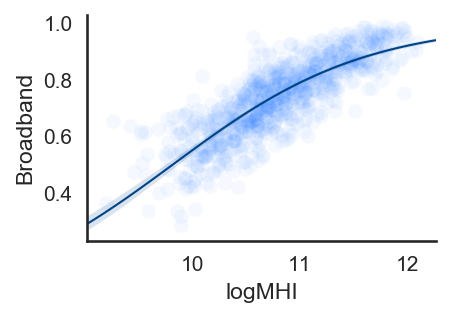

In [12]:
import seaborn as sns
sns.set_style("white")

fig, ax = plt.subplots(figsize = (3, 2))

ax.set_xlabel("Log Median Household Income")
ax.set_ylabel("Has Broadband")

sns.regplot(data = chicago, x = "logMHI", y = "Broadband", 
            scatter_kws = {"alpha" : 0.04, "s" : 50, "color" : "#0066FF"}, 
            line_kws    = {"lw" : 1, "color" : "#004488"}, 
            logistic = True, ax = ax)

fig.savefig("broadband_income.pdf")

In [13]:
import statsmodels.formula.api as smf

from statsmodels.discrete.discrete_model import Logit as logit, Probit as probit

In [14]:
chicago["C"] = 1  ## Add a constant

In [15]:
exog = ["logMHI", "nisp", "n25a", "BA", "Black", "Hispanic", "C"]
logit(chicago.Broadband, chicago[exog]).fit().summary()    

Optimization terminated successfully.
         Current function value: 0.449327
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Broadband   No. Observations:                  793
Model:                          Logit   Df Residuals:                      786
Method:                           MLE   Df Model:                            6
Date:                Tue, 01 Sep 2020   Pseudo R-squ.:                  -2.561
Time:                        12:41:28   Log-Likelihood:                -356.32
converged:                       True   LL-Null:                       -100.06
                                        LLR p-value:                     1.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
logMHI         0.6444      0.267      2.413      0.016       0.121       1.168
nisp           0.0005      0.445      0.001      0.999      -0.871       0.872
n25a           0.0341      0.472      0.072      0.942      -0.892       0.960
BA             1.7714      1.329      1.333      0.182      -0.833       4.375
Black         -0.3080      0.484     -0.637      0.524      -1.256       0.640
Hispanic      -0.2266      0.574     -0.395      0.693      -1.351       0.898
C             -6.2031      2.895     -2.142      0.032     -11.878      -0.528
==============================================================================
"""

In [16]:
for name, exog in {"MHI"  : ["logMHI", "C"],
                   "ACS"  : ["logMHI", "BA", "Black", "Hispanic", "C"],
                   "Race" : ["Black", "Hispanic", "C"],
                   "FCC"  : ["nisp", "n25a", "C"],
                   "All"  : ["nisp", "n25a", "logMHI", "BA", "Black", "Hispanic", "C"],
                  }.items():

    lfit = logit(chicago.Broadband, chicago[exog]).fit()
    chicago["pred" + name] = lfit.predict(chicago[exog])
    
print("\n ** CORRELATIONS FOR PREDICTED LOGIT MODELS **")
chicago.corr().Broadband.abs().sort_values(ascending = False).filter(regex = "pred", axis = 0)

Optimization terminated successfully.
         Current function value: 0.452238
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.449407
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.458442
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484267
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.449327
         Iterations 6

 ** CORRELATIONS FOR PREDICTED LOGIT MODELS **


predAll     0.863964
predACS     0.863186
predMHI     0.818691
predRace    0.762860
predFCC     0.339664
Name: Broadband, dtype: float64

So basically, it looks like this "saturates" on money.  Having 25 Mbps just depends on log household income.

Note that this is pretty different from what they did in the ML lab, where the outcome was whether or not broadband was contractually available.  In the case of the BDT / forest, nISP is particularly well suited, since it aligns with the geography of the contractual availability (suppliers generally offer broadband within their service territory).  That means that you have a binary choice that cleanly cuts broadband / no broadband.  Again, note the contractual availability is probably not the right metric.

In [20]:
for c in cities:
    cl = c.replace(" ", "_").lower()
    city_geo = acs_fcc_geo.query("name == '{}'".format(c)).to_crs(epsg = 4326)
    
    os.remove("site/{}.geojson".format(cl))
    city_geo[["Broadband", "Computer", "BA", "logMHI", "Black", "Hispanic", "n100a", "n25a", "maxdowna", "geom"]]\
      .to_file("site/{}.geojson".format(cl), driver = "GeoJSON")